In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from src.Graph import SingleGeneGraph
from src.Function import read_spatial_expression
from src import Preprocess
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def spatial_plot(adata, color, map = 'bwr'):
    sc.set_figure_params(facecolor="white", figsize=(8, 8))
    ax=sc.pl.scatter(adata,alpha=1,x="array_row",y="array_col", color = color, 
                 title=color,show=False,size=500000/adata.shape[0],
                 color_map=map,frameon=False)
    ax.set_aspect('equal', 'box')
    # ax.axes.invert_yaxis()

In [3]:
kneighbors, beta = 4,2
dataDir = "../dataset/MOB-breast_cancer/Rep11_MOB_count_matrix-1.tsv"
locs, data, _ = read_spatial_expression(dataDir)
locsDf = pd.DataFrame(locs, columns=["imagerow", "imagecol"])
locsDf.index = data.index
adata = sc.AnnData(X=data, obs=locsDf)
adata = Preprocess.data_preprocess(adata)
new_index = ["array_row", "array_col"]
adata.obs.rename(
    columns={"imagerow": new_index[0], "imagecol": new_index[1]}, inplace=True
)

raw data dim: (262, 16218)
Number of expressed genes a spot must have to be kept (0.01% of total expressed genes) 3375
Marked 3 spots
Removing genes that are expressed in less than 3 spots with a count of at least 1
Dropped 1559 genes


In [4]:
exp = adata.to_df()
coord = adata.obs[['array_row', 'array_col']]
targetGene= "Slc17a7"

In [5]:
geneGraph = SingleGeneGraph(targetGene, exp = exp, coord = coord, kneighbors = kneighbors, verbose=True)

In [10]:
geneGraph = SingleGeneGraph(targetGene, exp = exp, coord = coord, kneighbors = kneighbors, verbose=True)
geneGraph.mrf_with_icmem(beta = 3, exp_update=True, alpha=0.05, theta=0.2)
print (geneGraph.exp[:5])

100%|██████████| 8/8 [00:00<00:00, 26.51it/s]

[[ 0.75337576  0.36063886]
 [-0.73811643  0.20777377]]
[0.22650159 1.35190211 0.70169491 1.34450608 0.70806163]


In [51]:
geneGraph = SingleGeneGraph(targetGene, exp = exp, coord = coord, kneighbors = kneighbors, verbose=True)
geneGraph.mrf_with_icmem(beta = 3, update_exp=False,alpha=0.3, theta=0.2)
print (geneGraph.exp[:5])

100%|██████████| 10/10 [00:00<00:00, 26.57it/s]

[[ 0.70727708  0.21457412]
 [-0.78656467  0.69050714]]
[ 0.3284552   0.19678135  1.8354124  -0.23111588  0.99813765]


/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/scanpy/plotting/_utils.py:715: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


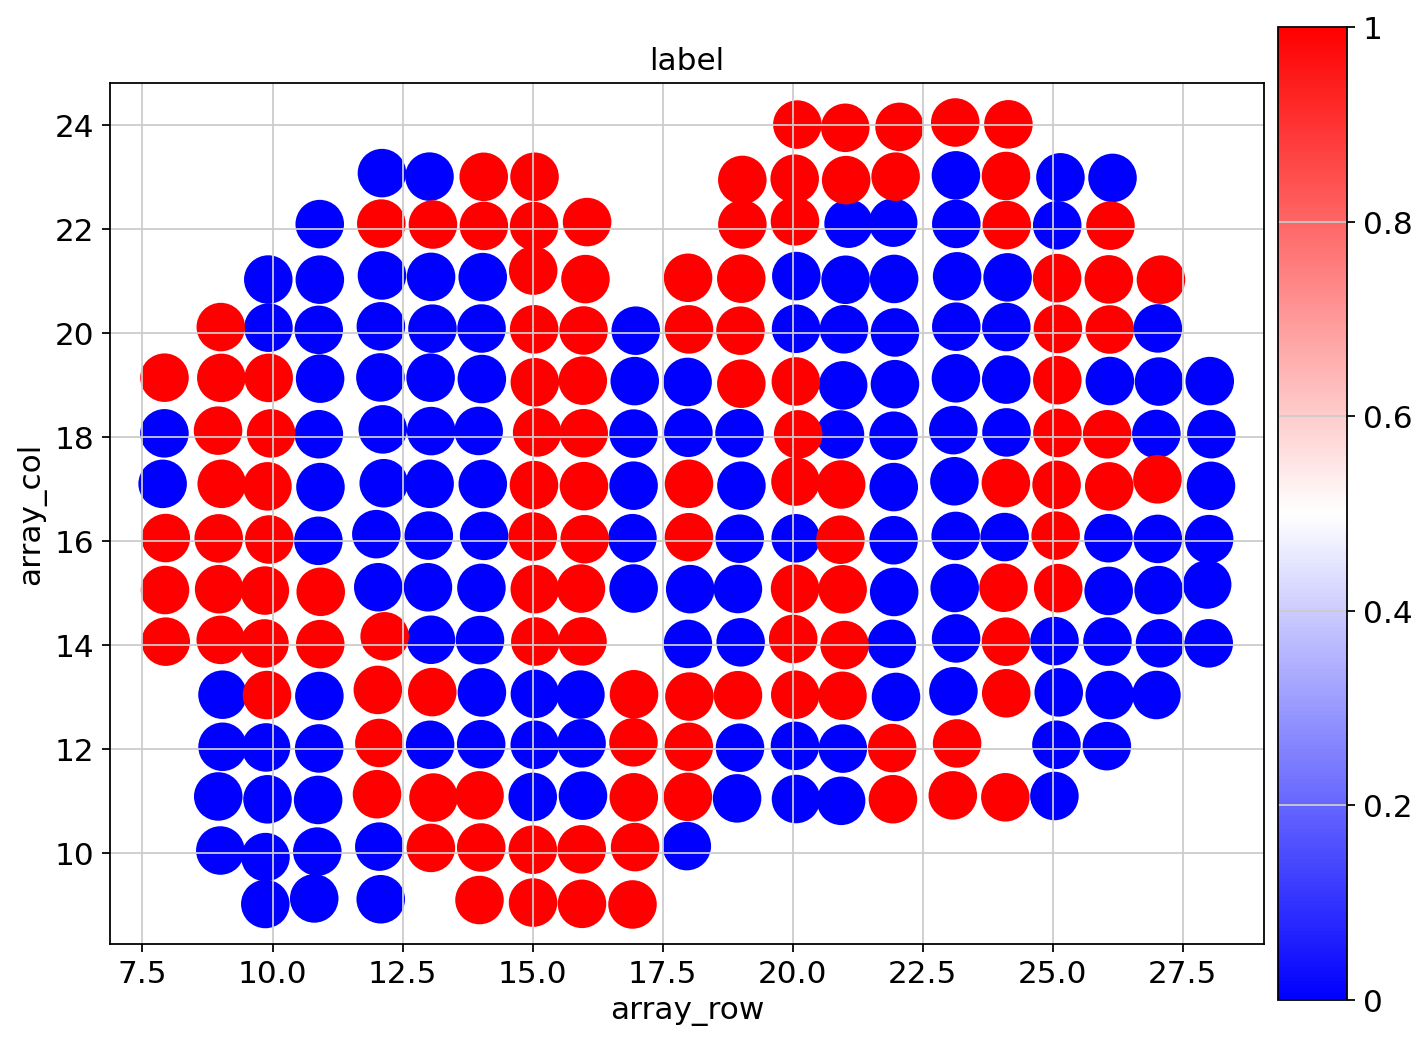

In [31]:
label = geneGraph.label
adata.obs['label'] = label
spatial_plot(adata, 'label')

/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/scanpy/plotting/_utils.py:715: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


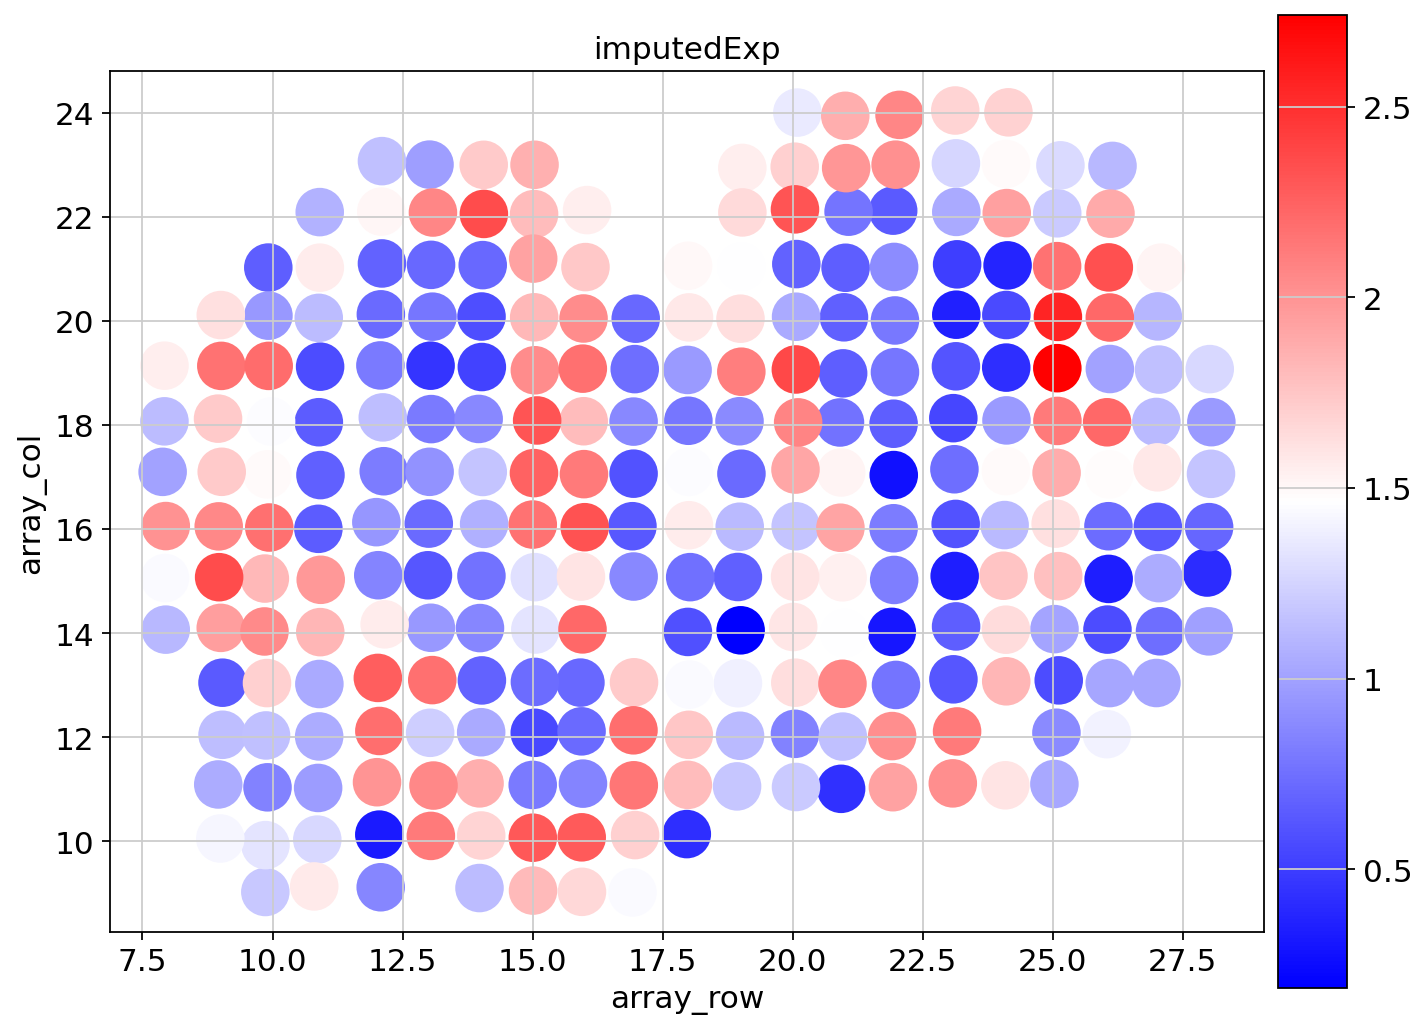

In [32]:
adata.obs['imputedExp'] = geneGraph.exp
spatial_plot(adata, 'imputedExp')

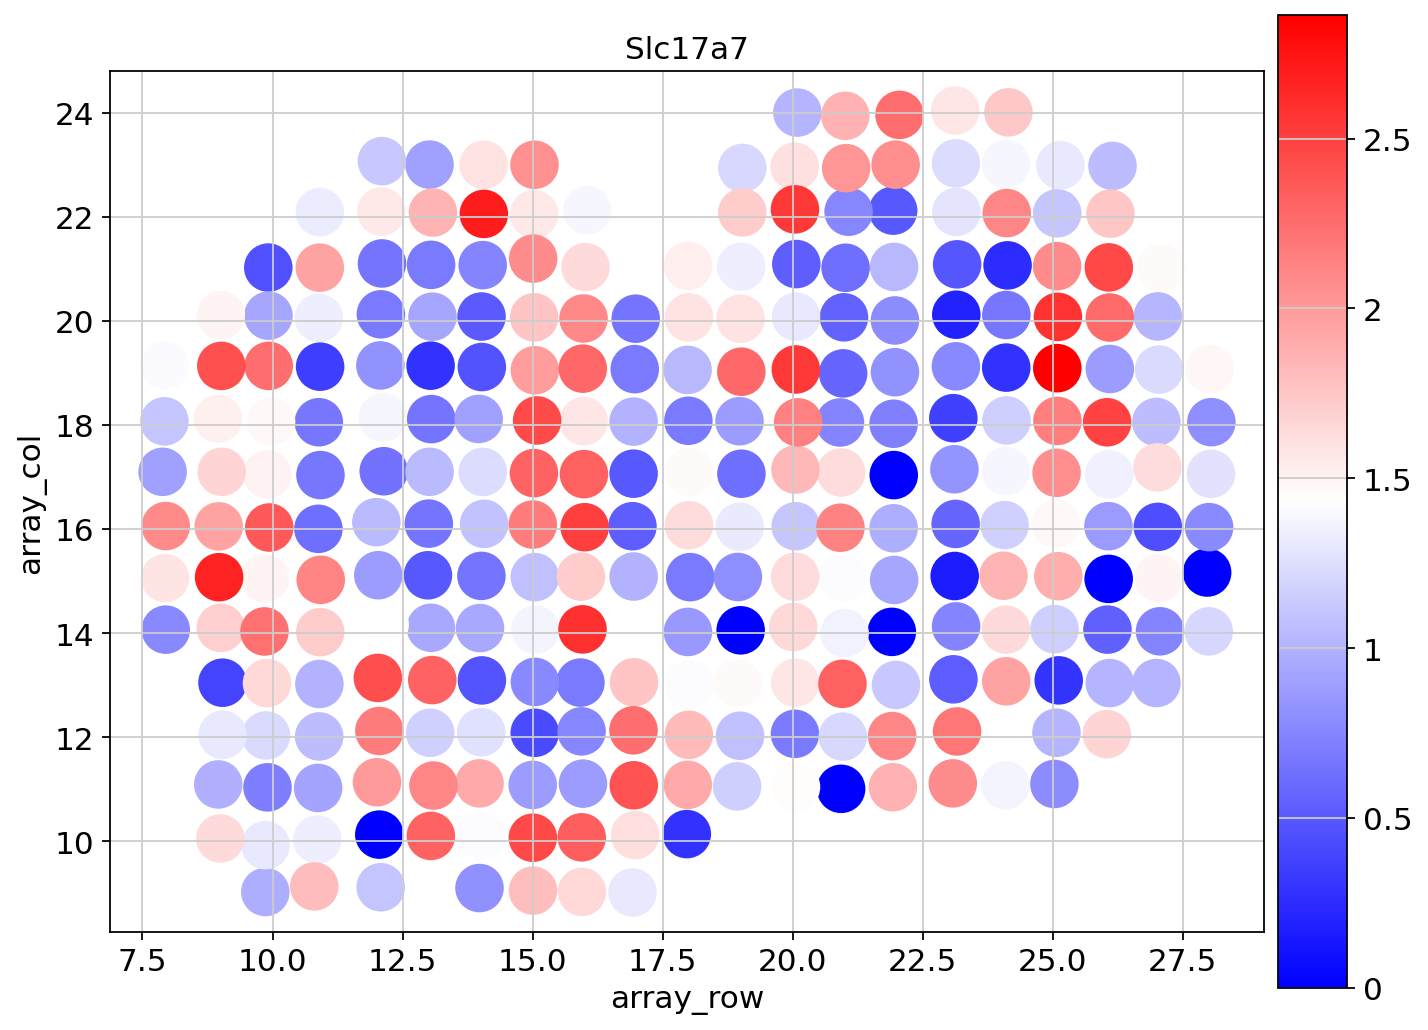

In [33]:
spatial_plot(adata, targetGene)

In [12]:
means, vars = geneGraph.clsPara.T

In [19]:
sqrt2pi = np.sqrt(2 * np.pi)

In [13]:
vars[np.isclose(vars, 0)] = 1e-5
expDiffSquared = (geneGraph.exp[:, None] - means) ** 2

In [16]:
geneGraph.exp[:,None] - means

array([[-5.26874166e-01,  9.64618022e-01],
       [ 5.98526348e-01,  2.09001854e+00],
       [-5.16808536e-02,  1.43981133e+00],
       [ 5.91130323e-01,  2.08262251e+00],
       [-4.53141307e-02,  1.44617806e+00],
       [-1.38581276e+00,  1.05679429e-01],
       [-1.86654374e+00, -3.75051554e-01],
       [-1.81574335e+00, -3.24251161e-01],
       [-9.71799329e-01,  5.19692859e-01],
       [-1.19933328e+00,  2.92158909e-01],
       [-2.79461165e-01,  1.21203102e+00],
       [-1.01849597e+00,  4.72996222e-01],
       [ 4.17412964e-02,  1.53323348e+00],
       [-1.90185211e-01,  1.30130698e+00],
       [ 7.51632737e-01,  2.24312492e+00],
       [-1.51167805e+00, -2.01858642e-02],
       [ 8.50063268e-01,  2.34155546e+00],
       [-1.45364646e+00,  3.78457236e-02],
       [ 4.14535929e-01,  1.90602812e+00],
       [ 1.43983307e-01,  1.63547550e+00],
       [ 5.14739405e-01,  2.00623159e+00],
       [-2.30586251e-01,  1.26090594e+00],
       [-1.75853985e+00, -2.67047663e-01],
       [-9.

In [30]:
clusterProb = np.exp(-0.5 * expDiffSquared / vars) / (
                    sqrt2pi * np.sqrt(vars)
                )
clusterProb/clusterProb.sum(axis=1)[:, None]

array([[8.29006731e-01, 1.70993269e-01],
       [9.99941092e-01, 5.89076595e-05],
       [9.91069556e-01, 8.93044407e-03],
       [9.99937321e-01, 6.26794921e-05],
       [9.91459782e-01, 8.54021806e-03],
       [5.15908354e-02, 9.48409165e-01],
       [8.42986823e-03, 9.91570132e-01],
       [1.00145599e-02, 9.89985440e-01],
       [2.81889355e-01, 7.18110645e-01],
       [1.12590947e-01, 8.87409053e-01],
       [9.58953989e-01, 4.10460113e-02],
       [2.35859386e-01, 7.64140614e-01],
       [9.95408731e-01, 4.59126891e-03],
       [9.77005644e-01, 2.29943563e-02],
       [9.99984104e-01, 1.58963429e-05],
       [3.09795428e-02, 9.69020457e-01],
       [9.99993323e-01, 6.67724794e-06],
       [3.90938207e-02, 9.60906179e-01],
       [9.99733158e-01, 2.66841820e-04],
       [9.97833135e-01, 2.16686477e-03],
       [9.99881784e-01, 1.18216483e-04],
       [9.70013632e-01, 2.99863679e-02],
       [1.22297810e-02, 9.87770219e-01],
       [3.61293125e-01, 6.38706875e-01],
       [9.999503

In [31]:
sumArray = clusterProb.sum(axis=1)[:, None]

In [38]:
sumArray[0,]  = np.nan

In [39]:
clusterProb/sumArray

array([[           nan,            nan],
       [9.99941092e-01, 5.89076595e-05],
       [9.91069556e-01, 8.93044407e-03],
       [9.99937321e-01, 6.26794921e-05],
       [9.91459782e-01, 8.54021806e-03],
       [5.15908354e-02, 9.48409165e-01],
       [8.42986823e-03, 9.91570132e-01],
       [1.00145599e-02, 9.89985440e-01],
       [2.81889355e-01, 7.18110645e-01],
       [1.12590947e-01, 8.87409053e-01],
       [9.58953989e-01, 4.10460113e-02],
       [2.35859386e-01, 7.64140614e-01],
       [9.95408731e-01, 4.59126891e-03],
       [9.77005644e-01, 2.29943563e-02],
       [9.99984104e-01, 1.58963429e-05],
       [3.09795428e-02, 9.69020457e-01],
       [9.99993323e-01, 6.67724794e-06],
       [3.90938207e-02, 9.60906179e-01],
       [9.99733158e-01, 2.66841820e-04],
       [9.97833135e-01, 2.16686477e-03],
       [9.99881784e-01, 1.18216483e-04],
       [9.70013632e-01, 2.99863679e-02],
       [1.22297810e-02, 9.87770219e-01],
       [3.61293125e-01, 6.38706875e-01],
       [9.999503